In [15]:
from pathlib import Path
import re

import matplotlib.animation as anim
import matplotlib.pyplot as plt
import matplotlib.image as mimg

In [11]:
cd ..

/userdata/jgauthier/projects/ideal-word-representations


In [64]:
study_models = [
    "librispeech-train-clean-100/w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames",
    "librispeech-train-clean-100/w2v2_8/rnn_8-weightdecay0.01/phoneme_10frames",
    "librispeech-train-clean-100/w2v2_8/randomrnn_32/random"
]

In [65]:
frames = {}
for study_model in study_models:
    frames_i = list(Path(f"outputs/notebooks/{study_model}/rsa_phoneme/").glob("*.png"))
    frames_i = {int(re.search(r"(\d+).png", str(f)).group(1)): f for f in frames_i}
    frames[study_model] = frames_i

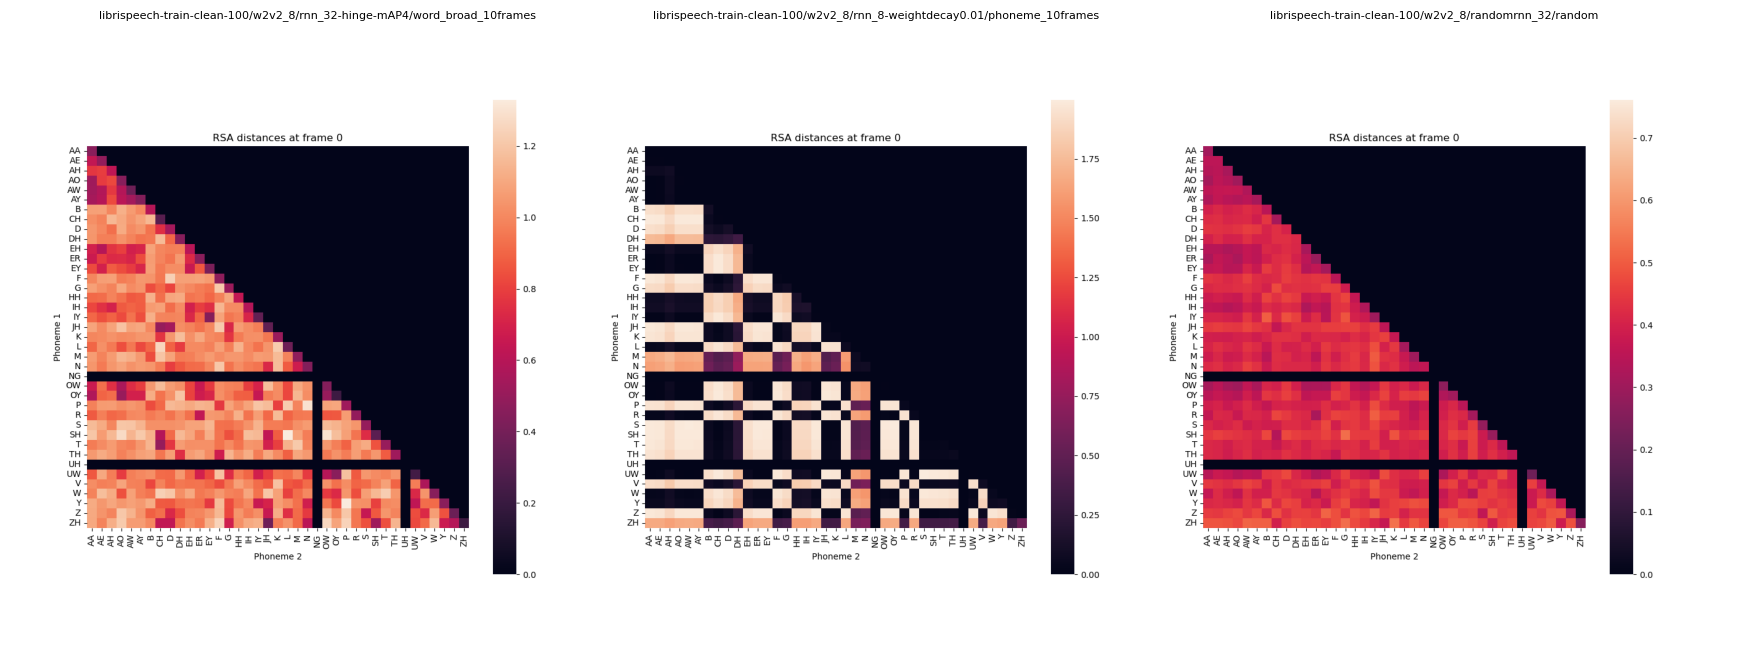

In [66]:
f, axs = plt.subplots(1, len(frames), figsize=(8 * len(frames), 8))
# reduce spacing
plt.subplots_adjust(wspace=-0.25, hspace=0)
for study_model, ax in zip(frames, axs.flat):
    ax.axis("off")
    ax.set_title(study_model, fontsize=8)

def animate(i):
    for study_model, ax in zip(frames, axs.flat):
        im = plt.imread(frames[study_model][i])
        ax.imshow(im)

num_frames = len(frames[study_models[0]])
ani = anim.FuncAnimation(f, animate, frames=num_frames, interval=100)
ani.save("summary_notebooks/rsa_phoneme.gif", writer="imagemagick", fps=2)

In [ ]:
# TODO
# load the underlying matrices
# quantitative match between study models (Spearman-correlate the matrices)
# clustermap on the first frame of word model, qualitatively analyze